In [ ]:
!pip install kagglehub

In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/shoppersentiments")

print("Path to dataset files:", path)

In [ ]:
!pip install haystack-ai
!pip install azure-ai-search-haystack

In [3]:
import pandas as pd
from json import loads, dumps

path = "/Users/amna.mubashar/.cache/kagglehub/datasets/nelgiriyewithana/shoppersentiments/versions/1/TeePublic_review.csv"
# First read the CSV with pandas to handle encoding issues

df = pd.read_csv(path, encoding='latin1', skiprows=range(1,40), nrows=25)  # or try 'iso-8859-1', 'cp1252'

df.rename(columns={'review-label': 'rating'}, inplace=True)
df['year'] = pd.to_datetime(df['year'], format='%Y %H:%M:%S').dt.year

# Convert DataFrame to JSON
json_data = {"reviews": loads(df.to_json(orient="records"))}


In [ ]:
!pip install jq

In [4]:
from haystack.components.converters import JSONConverter
from haystack.dataclasses import ByteStream
converter = JSONConverter(
  jq_schema=".reviews[]", content_key="review", extra_meta_fields={"store_location", "date", "month", "year", "rating"}
)
source = ByteStream.from_string(dumps(json_data))

results = converter.run(sources=[source])
print (results["documents"][2])


Document(id=48baf64e8784ca4a7c2b61dc8bd57bb8d86ea4306e3c24b6a43558f2b2f90581, content: 'Fast shipping, great quality, but the sizing was WAY off - my shirt doesn't fit me whatsoever.', meta: {'rating': 3, 'month': 6, 'store_location': 'US', 'date': 2023, 'year': 2019})


In [ ]:
!pip install nltk=="3.9.1"

In [5]:
from haystack.components.preprocessors import DocumentCleaner
cleaner = DocumentCleaner(ascii_only=True, remove_regex="i12i12i12")
cleaned_documents=cleaner.run(documents=results["documents"], )

print (cleaned_documents)


{'documents': [Document(id=034938918e38a4e876b4d3481eef1b20b4a223dd1a1992c9a09e7d5b9a5f7731, content: 'The screen prints look good however 2 out of the 3 that I ordered are crooked. Theyre not horribly c...', meta: {'rating': 3, 'month': 6, 'store_location': 'US', 'date': 2023, 'year': 2017}), Document(id=d75e72a14f123d0378643a044f5bffd96161115d32ce4a2829199c8b904d1f8b, content: 'I had to make a return for a larger size tee shirt and it was no hassle and communication was fantas...', meta: {'rating': 5, 'month': 6, 'store_location': 'US', 'date': 2023, 'year': 2019}), Document(id=48baf64e8784ca4a7c2b61dc8bd57bb8d86ea4306e3c24b6a43558f2b2f90581, content: 'Fast shipping, great quality, but the sizing was WAY off - my shirt doesn't fit me whatsoever.', meta: {'rating': 3, 'month': 6, 'store_location': 'US', 'date': 2023, 'year': 2019}), Document(id=524f924718427580bc65f6cb814f04c60c94c568fccd9f2cd5c13699adeb94a2, content: 'I ordered a Tshirt for both of my girls. "Resting stitch face" t s

In [7]:
from haystack import Pipeline
from haystack.components.embedders import AzureOpenAITextEmbedder, AzureOpenAIDocumentEmbedder
from haystack.components.writers import DocumentWriter
from azure.search.documents.indexes.models import (
    SemanticConfiguration,
    SemanticField,
    SemanticPrioritizedFields,
    SemanticSearch
)

from haystack_integrations.document_stores.azure_ai_search import AzureAISearchDocumentStore


semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        content_fields=[SemanticField(field_name="content")]
    )
)

# Create the semantic settings with the configuration
semantic_search = SemanticSearch(configurations=[semantic_config])

document_store = AzureAISearchDocumentStore(index_name="customer-reviews-analysis", azure_endpoint="",
    api_key="",
    embedding_dimension=1536, metadata_fields = {"month": int, "year": int, "rating": int, "store_location": str}, semantic_search=semantic_search)

# Indexing Pipeline
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_embedder", AzureOpenAIDocumentEmbedder())
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="doc_writer")
indexing_pipeline.connect("document_embedder", "doc_writer")

indexing_pipeline.run({"document_embedder": {"documents": cleaned_documents["documents"]}})



Embedding Texts: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


{'document_embedder': {'meta': {'model': 'ada',
   'usage': {'prompt_tokens': 902, 'total_tokens': 902}}},
 'doc_writer': {'documents_written': 25}}

In [8]:
from haystack_integrations.components.retrievers.azure_ai_search import AzureAISearchHybridRetriever

# Query Pipeline
query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", AzureOpenAITextEmbedder())
query_pipeline.add_component("retriever", AzureAISearchHybridRetriever(document_store=document_store, query_type="semantic", semantic_configuration_name="my-semantic-config", top_k=10))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")



🚅 Components
  - text_embedder: AzureOpenAITextEmbedder
  - retriever: AzureAISearchHybridRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

In [9]:
query = "Which reviews are about shipping?"

result = query_pipeline.run({"text_embedder": {"text": query}, "retriever": {"query": query}})

<iterator object azure.core.paging.ItemPaged at 0x17d9093d0>


In [10]:
retrieved_reviews = result["retriever"]["documents"]
for i, doc in enumerate(retrieved_reviews):
    print (f"{i+1}. {doc.content}")


1. Product was great. Love the options. anything I could imagine was available. my only issue was I paid extra for 4-6 shipping and got the shirts 9 days after order. I will try again tho.Thank you
2. Product was great. Love the options. anything I could imagine was available. my only issue was I paid extra for 4-6 shipping and got the shirts 9 days after order. I will try again tho.Thank you
3. Once I figured out the sizing, everything was great. FYI, I am a size 10 in womens tops but prefer a looser fit for a crew neck tee. The 3X fits like a size Large tee from J. Crew. The shipping is a bit slow, but not too bad. Love my tees. This is my second order.
4. Once I figured out the sizing, everything was great. FYI, I am a size 10 in womens tops but prefer a looser fit for a crew neck tee. The 3X fits like a size Large tee from J. Crew. The shipping is a bit slow, but not too bad. Love my tees. This is my second order.
5. Love the way everything was packed nicely folded with fast effici

In [ ]:
!pip install jsonschema

# TOOL USING ASPECT BASED SENTIMENT ANALYSIS


In [29]:
!pip install vaderSentiment
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_sentiment_distribution(topics):
    # Create DataFrame from topics data
    data = [(topic, review['sentiment']['analyzer_rating'], 
             review['review']['rating'], review['sentiment']['label'])
            for topic, reviews in topics.items()
            for review in reviews]
    
    df = pd.DataFrame(data, columns=['Topic', 'Normalized Score', 'Original Rating', 'Sentiment'])
    
    # Calculate means
    df_means = df.groupby('Topic').agg({
        'Normalized Score': 'mean',
        'Original Rating': 'mean'
    }).reset_index()
    
    fig, ax = plt.subplots(figsize=(8, 4))  # Reduced from (12, 6)
    x = np.arange(len(df_means))
    bar_width = 0.3  # Reduced from 0.35
    
    # Colors for sentiment
    colors = {
        'positive': '#2ecc71',
        'neutral': '#f1c40f',
        'negative': '#e74c3c'
    }
    
    # Create bars
    sentiment_colors = [colors[df.groupby('Topic')['Sentiment'].agg(lambda x: x.mode()[0])[topic]] 
                       for topic in df_means['Topic']]
    
    bars1 = ax.bar(x - bar_width/2, df_means['Normalized Score'], 
                   bar_width, label='Normalized Score', color=sentiment_colors)
    bars2 = ax.bar(x + bar_width/2, df_means['Original Rating'], 
                   bar_width, label='Original Rating', color='gray', alpha=0.7)
    
    # Customize plot with smaller font sizes
    ax.set_ylabel('Score', fontsize=9)
    ax.set_title('Average Sentiment Scores by Topic', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(df_means['Topic'], rotation=45, ha='right', fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels with smaller font size
    for bars in [bars1, bars2]:
        ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)
    
    # Smaller legend
    ax.legend(handles=[plt.Rectangle((0,0),1,1, color=c) for c in colors.values()] + 
             [plt.Rectangle((0,0),1,1, color='gray', alpha=0.7)],
             labels=list(colors.keys()) + ['Original Rating'],
             loc='upper right',
             fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [35]:
from haystack.tools import Tool
from haystack.components.tools import ToolInvoker

from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import AzureOpenAIChatGenerator, OpenAIChatGenerator
from typing import Dict, List
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


def analyze_sentiment(reviews: List[Dict]) -> Dict:
    """
    Perform aspect-based sentiment analysis.
    
    For each review that mentions keywords related to a specific topic, the function computes 
    sentiment scores using VADER and categorizes the sentiment as 'positive', 'negative', or 'neutral'.
    
    """
    topics = {
        "product_quality": [],
        "shipping": [],
        "customer_service": [],
        "pricing": []
    }
    
    # Define keywords for each topic
    keywords = {
        "product_quality": ["quality", "material", "design", "fit", "size", "color", "style"],
        "shipping": ["shipping", "delivery", "arrived"],
        "customer_service": ["service", "support", "help"],
        "pricing": ["price", "cost", "expensive", "cheap"]
    }

    
    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    for review in reviews:
        text = review.get("review", "").lower()
        for topic, words in keywords.items():
            if any(word in text for word in words):
                # Compute sentiment scores using VADER
                sentiment_scores = analyzer.polarity_scores(text)
               
                compound = sentiment_scores['compound']
                # Normalize compound score from [-1, 1] to [1, 5]
                normalized_score = (compound + 1) * 2 + 1
                
                if compound >= 0.05:
                    sentiment_label = 'positive'
                elif compound <= -0.05:
                    sentiment_label = 'negative'
                else:
                    sentiment_label = 'neutral'
                
                # Append the review along with its sentiment analysis result
                topics[topic].append({
                    "review": review,
                    "sentiment": {
                        "analyzer_rating": normalized_score,
                        "label": sentiment_label
                    }
                })
        
    plot_sentiment_distribution(topics)

    return {
        "total_reviews": len(reviews),
        "sentiment_scores": sentiment_scores,
        "topics": topics,
        "average_rating": sum(r.get("rating", 3) for r in reviews) / len(reviews)
    }

# Create the aspect based sentiment analysis tool
sentiment_tool = Tool(
    name="review_analysis",
    description="Aspect based sentiment analysis tool that compares the sentiment of reviews by analyzer and rating",
    function=analyze_sentiment,
    parameters={
        "type": "object",
        "properties": {
            "reviews": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "review": {"type": "string"},
                        "rating": {"type": "integer"},
                        "date": {"type": "string"}
                    }
                }
            },
        },
        "required": ["reviews"]
    }
)



In [ ]:
!pip install sumy

In [17]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

def summarize_reviews(reviews: List[Dict]) -> Dict:
    """
    Summarize the reviews by extracting key sentences.
    """
    summaries = []
    summarizer = LsaSummarizer()
    for review in reviews:
        text = review.get("review", "")
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = summarizer(parser.document, 2)  # Adjust the number of sentences as needed
        summary_text = " ".join(str(sentence) for sentence in summary)
        summaries.append({"review": text, "summary": summary_text})

    return {"summaries": summaries}

# Create the text summarization tool
summarization_tool = Tool(
    name="review_summarization",
    description="Tool to summarize customer reviews by extracting key sentences.",
    function=summarize_reviews,
    parameters={
        "type": "object",
        "properties": {
            "reviews": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "review": {"type": "string"},
                        "rating": {"type": "integer"},
                        "date": {"type": "string"}
                    }
                }
            },
        },
        "required": ["reviews"]
    }
)

In [37]:
def create_review_assistant():
    """Creates an interactive review analysis assistant"""
    
    # replace with AzureOpenAIChatGenerator after Haystack 2.10.0 release 
    chat_generator = OpenAIChatGenerator(
        tools=[sentiment_tool, summarization_tool]
    )
    
    system_message = ChatMessage.from_system(
        """
        You are a customer review analysis expert. Your task is to perform aspect based sentiment analysis on customer reviews.
        You can use two tools to get insights:
        - review_analysis: to get the sentiment of reviews by analyzer and rating
        - review_summarization: to get the summary of reviews.

        Depending on the user's question, use the appropriate tool to get insights and explain them in a helpful way. 
        
        """
    )
    
    return chat_generator, system_message

tool_invoker = ToolInvoker(tools=[sentiment_tool, summarization_tool])


/Users/amna.mubashar/Library/Python/3.9/lib/python/site-packages/haystack/components/tools/tool_invoker.py:123: UserWarning: The `ToolInvoker` component is experimental and its API may change in the future.
  warnings.warn(msg)



🧑: Whats the sentiment distribution in our reviews?
⌛ iterating...

 TOOL CALL:
	review_analysis


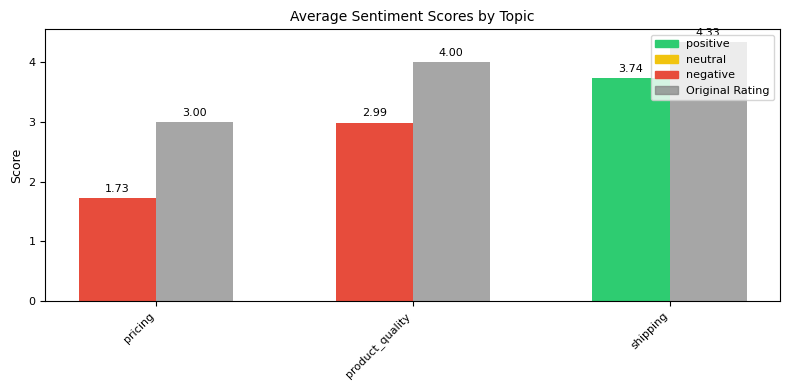

⌛ iterating...
🤖: The sentiment distribution in your reviews is as follows:

- **Positive Sentiment**: 38.8%
- **Neutral Sentiment**: 61.2%
- **Negative Sentiment**: 0.0%

In summary, there are no negative sentiments reported in the reviews, with a significant portion being neutral. This suggests that while customers may have positive experiences, there could be many reviews that do not express strong feelings either way.

### Breakdown of Average Rating:
The average rating across the reviews is **4.4**, indicating a generally favorable perception of your product.

### Key Themes Identified:
1. **Product Quality**:
   - Positive reviews highlight great product options and overall satisfaction after figuring out sizing.
   - A negative sentiment appears related to pricing being perceived as high.

2. **Shipping**:
   - Customers expressed positive feelings about efficient delivery and packing.

3. **Pricing**:
   - There are concerns about prices being seen as high for the products, par

In [38]:
# Create the review assistant
chat_generator, system_message = create_review_assistant()

# Initialize messages with the system message
messages = [system_message]

# Interactive loop for user input
while True:
    user_input = input("\n\nwaiting for input (type 'exit' or 'quit' to stop)\n: ")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))

    print (f"\n🧑: {user_input}")
    # Build the prompt with user input and reviews
    user_prompt = ChatMessage.from_user(f"""
    {user_input}
    Here are the reviews:
    {retrieved_reviews}
    analysis_type: "topics"
    """)
    messages.append(user_prompt)

    while True:
        print("⌛ iterating...")

        replies = chat_generator.run(messages=messages)["replies"]
        messages.extend(replies)

        # Check for tool calls and handle them
        if not replies[0].tool_calls:
            break
        tool_calls = replies[0].tool_calls

        # Print tool calls for debugging
        for tc in tool_calls:
            print("\n TOOL CALL:")
            print(f"\t{tc.tool_name}")

        tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
        messages.extend(tool_messages)

    # Print the final AI response after all tool calls are resolved
    print(f"🤖: {messages[-1].text}")

